## Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

## Load datasets

In [2]:
customers_df = pd.read_csv("Customers.csv")  # Customer data
transactions_df = pd.read_csv("Transactions.csv")  # Transaction data

###  Preview the data

In [3]:
print("\nCustomers Data:\n")
customers_df.head()  # First 5 rows of Customers data


Customers Data:



,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [4]:
print("\nTransactions Data:\n")
transactions_df.head()  # First 5 rows of Transactions data



Transactions Data:



,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


### Data Overview

In [5]:

customers_info = customers_df.info()
print("\n")
transactions_info = transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB


### Check for missing values

In [6]:

missing_values = {
    "Customers": customers_df.isnull().sum(),
    "Transactions": transactions_df.isnull().sum()
}

missing_values

{'Customers': CustomerID      0
 CustomerName    0
 Region          0
 SignupDate      0
 dtype: int64,
 'Transactions': TransactionID      0
 CustomerID         0
 ProductID          0
 TransactionDate    0
 Quantity           0
 TotalValue         0
 Price              0
 dtype: int64}

### Check for Duplicates values

In [7]:
duplicated_value = {
    "Customers": customers_df.duplicated().sum(),
    "Transactions": transactions_df.duplicated().sum()
}

duplicated_value

{'Customers': 0, 'Transactions': 0}

### Statistics for numerical columns

In [8]:
transactions_stats = transactions_df.describe()


transactions_stats

,Quantity,TotalValue,Price
count,1000.000000,1000.000000,1000.00000
mean,2.537000,689.995560,272.55407
std,1.117981,493.144478,140.73639
min,1.000000,16.080000,16.08000
25%,2.000000,295.295000,147.95000
50%,3.000000,588.880000,299.93000
75%,4.000000,1011.660000,404.40000
max,4.000000,1991.040000,497.76000


### Value counts for categorical columns

In [9]:

region_distribution = customers_df["Region"].value_counts()
region_distribution

South America    59
Europe           50
North America    46
Asia             45
Name: Region, dtype: int64

## Task : Customer Segmentation / Clustering

In [10]:
# Merge data to create a unified dataset for clustering
# Aggregate transaction-level data for each customer
customer_transactions = transactions_df.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total amount spent
    "Quantity": "sum"     # Total quantity purchased
}).reset_index()


In [11]:
# Merge with customer profile data
customer_data = customers_df.merge(customer_transactions, on="CustomerID", how="left").fillna(0)

customer_data

,CustomerID,CustomerName,Region,SignupDate,TotalValue,Quantity
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,12.0
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,10.0
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,14.0
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,23.0
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,7.0
...,...,...,...,...,...,...
195,C0196,Laura Watts,Europe,2022-06-07,4982.88,12.0
196,C0197,Christina Harvey,Europe,2023-03-21,1928.65,9.0
197,C0198,Rebecca Ray,Europe,2022-02-27,931.83,3.0
198,C0199,Andrea Jenkins,Europe,2022-12-03,1979.28,9.0


In [12]:
# Add dummy variables for the categorical 'Region' feature
customer_data = pd.get_dummies(customer_data, columns=["Region"], drop_first=True)

customer_data

,CustomerID,CustomerName,SignupDate,TotalValue,Quantity,Region_Europe,Region_North America,Region_South America
0,C0001,Lawrence Carroll,2022-07-10,3354.52,12.0,0,0,1
1,C0002,Elizabeth Lutz,2022-02-13,1862.74,10.0,0,0,0
2,C0003,Michael Rivera,2024-03-07,2725.38,14.0,0,0,1
3,C0004,Kathleen Rodriguez,2022-10-09,5354.88,23.0,0,0,1
4,C0005,Laura Weber,2022-08-15,2034.24,7.0,0,0,0
...,...,...,...,...,...,...,...,...
195,C0196,Laura Watts,2022-06-07,4982.88,12.0,1,0,0
196,C0197,Christina Harvey,2023-03-21,1928.65,9.0,1,0,0
197,C0198,Rebecca Ray,2022-02-27,931.83,3.0,1,0,0
198,C0199,Andrea Jenkins,2022-12-03,1979.28,9.0,1,0,0


In [13]:
# Standardize the data for clustering
features = customer_data.drop(columns=["CustomerID", "CustomerName", "SignupDate"])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_features

array([[-0.05188436, -0.1107351 , -0.57735027, -0.54653573,  1.54590766],
       [-0.86271433, -0.43404927, -0.57735027, -0.54653573, -0.64686916],
       [-0.393842  ,  0.21257907, -0.57735027, -0.54653573,  1.54590766],
       [ 1.03537505,  1.66749283, -0.57735027, -0.54653573,  1.54590766],
       [-0.76949861, -0.91902053, -0.57735027, -0.54653573, -0.64686916],
       [ 0.42264614, -0.1107351 , -0.57735027, -0.54653573,  1.54590766],
       [-0.47295849, -0.75736344, -0.57735027, -0.54653573, -0.64686916],
       [ 0.44658328,  1.18252158, -0.57735027,  1.82970656, -0.64686916],
       [-1.38789656, -1.56564887,  1.73205081, -0.54653573, -0.64686916],
       [-0.94162972, -0.1107351 ,  1.73205081, -0.54653573, -0.64686916],
       [ 0.15220099,  0.05092198, -0.57735027, -0.54653573,  1.54590766],
       [ 0.96818364,  1.02086449, -0.57735027, -0.54653573,  1.54590766],
       [ 1.38632271,  0.85920741, -0.57735027, -0.54653573,  1.54590766],
       [-1.70197101, -1.72730595,  1.7

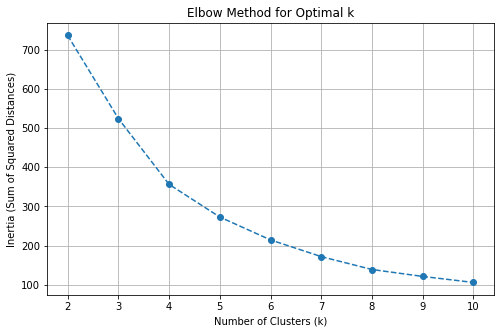

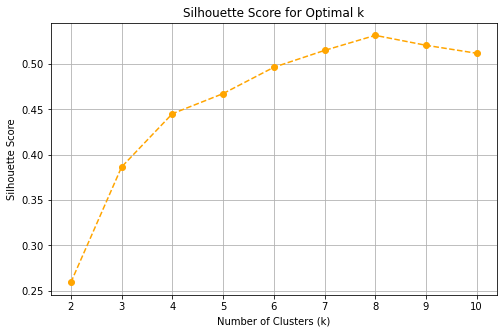

In [14]:
# Determine the optimal number of clusters using the Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []

k_values = range(2, 11)  # Check for k between 2 and 10
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    inertia.append(kmeans.inertia_)  # Sum of squared distances to the closest cluster center
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.xticks(k_values)
plt.grid()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='--', color='orange')
plt.title("Silhouette Score for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid()
plt.show()


In [15]:

# Choose the optimal number of clusters (e.g., from Elbow Method or Silhouette Score analysis)
optimal_k = 6  # Replace with the chosen value after analyzing the plots

# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Assign cluster labels to the customer data
customer_data["Cluster"] = clusters

# Evaluate clustering performance
db_index = davies_bouldin_score(scaled_features, clusters)
silhouette_avg = silhouette_score(scaled_features, clusters)

# Print clustering evaluation metrics
print(f"Optimal Number of Clusters: {optimal_k}")
print(f"Davies-Bouldin Index: {db_index:.2f}")
print(f"Silhouette Score: {silhouette_avg:.2f}")


Optimal Number of Clusters: 6
Davies-Bouldin Index: 0.77
Silhouette Score: 0.50


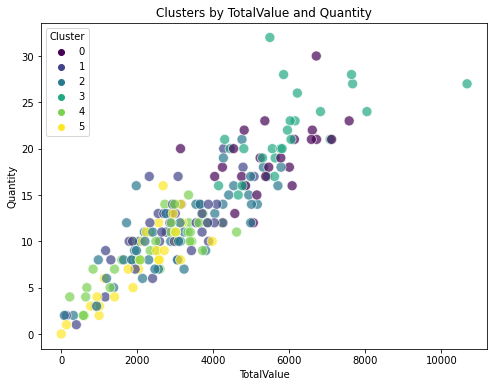

In [16]:
# Visualize the clusters using TotalValue and Quantity
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=customer_data["TotalValue"],
    y=customer_data["Quantity"],
    hue=customer_data["Cluster"],
    palette="viridis",
    s=100,
    alpha=0.7
)
plt.title("Clusters by TotalValue and Quantity")
plt.xlabel("TotalValue")
plt.ylabel("Quantity")
plt.legend(title="Cluster")
plt.show()




In [18]:
# Save clustered data to a CSV file
customer_data.to_csv("Avijit_Giri_Clustering.csv", index=False)
print("Clustered data saved to Avijit_Giri_Clustering.csv")

Clustered data saved to Avijit_Giri_Clustering.csv
